# Recurrent Neural Networks: Example 2 - Ice Cream Production

In this noteboook a real time series dataset is used to build a model and forecast future values.
The notebook is really equivalent to the example 1 (sales), but the notebook uses another dataset.

The used dataset was downloaded from the FRED website with data on **Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and Frozen Dessert (Not Seasonally Adjusted)**:

[https://fred.stlouisfed.org/series/IPN31152N](https://fred.stlouisfed.org/series/IPN31152N)

File:

`../../data/IPN31152N.csv`

`git_repositories/data_science_python_tools/data/IPN31152N.csv`

There is also a file provided in the course folder, not used here: `Frozen_Dessert_Production.csv`.

Note that the data is normalized so that 2017 has value 100.

**Important note 1: it makes sense to have date information instead of date strings to fully handle the time series.
Therefore, often date strings need to be converted into datetime type.**

**Important note 2: few comments are added here; to see more detailed notes, look at previous notebooks.**

## 1. Load and prepare dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df = pd.read_csv('../../data/IPN31152N.csv',index_col='DATE',parse_dates=True)

In [7]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332


In [10]:
df.columns = ['Production']

In [11]:
df.head()

,Production
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332


<AxesSubplot:xlabel='DATE'>

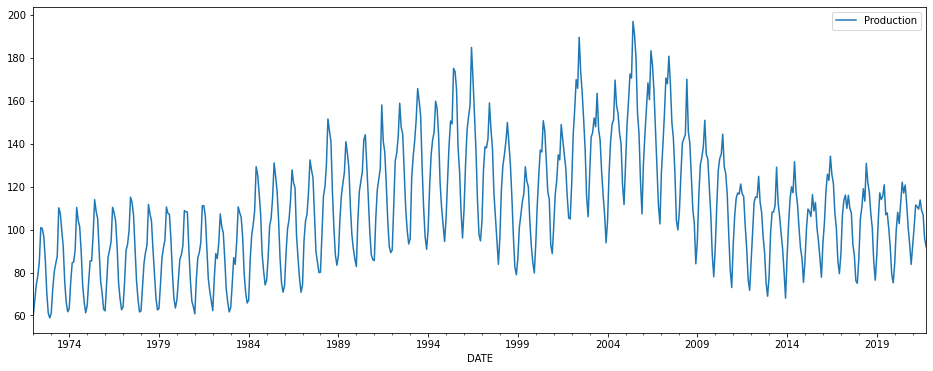

In [13]:
df.plot(figsize=(16,6))

### Train/Test Split

In [14]:
len(df)

598

In [15]:
# We take at least 24 months for the test split
# BUT: another option for testing is to take
# - the last 18 months for the test split
# - 12 months for the batch length
test_index = 24

In [17]:
train = df.iloc[:-test_index]
test = df.iloc[-test_index:]

In [18]:
len(test)

24

### Scale Data

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(train)

MinMaxScaler()

In [39]:
scaled_train = scaler.transform(train)

In [40]:
scaled_test = scaler.transform(test)

### Time Series Generator

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [29]:
# The length of the input series must be smaller than the length of the test split
# if we do early-stopping validdation
length = 18
batch_size = 1

In [30]:
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [31]:
# We check the first (X,y) pair of the generator
X,y = generator[0]

In [32]:
X

array([[[0.00946848],
        [0.06107908],
        [0.11324413],
        [0.1414343 ],
        [0.18979645],
        [0.30491195],
        [0.30149681],
        [0.27411766],
        [0.19733775],
        [0.08531415],
        [0.01561386],
        [0.        ],
        [0.01773963],
        [0.09849348],
        [0.1558762 ],
        [0.18355975],
        [0.20875515],
        [0.37144352]]])

In [33]:
y

array([[0.35419819]])

## 2. Create the Model

In [34]:
from tensorflow.keras.models import Sequential

In [35]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [36]:
n_features = 1
model = Sequential()
#model.add(SimpleRNN(units=100,input_shape=(length,n_features)))
# We explicitly use the ReLu activation
# We can also vary the number of units and see what happens
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

2021-12-21 12:24:09.829858: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 12:24:09.830439: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Early Stopping - Validation

In [41]:
# We need to create a validation generator
# The length is the same as before,
# taking into account that it must be shorter than the length of the validation split
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Train

In [44]:
# We train with an early stop callback
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
556/556 [==============================] - 113s 203ms/step - loss: 0.0277 - val_loss: 0.0039
Epoch 2/20
556/556 [==============================] - 111s 199ms/step - loss: 0.0141 - val_loss: 0.0067
Epoch 3/20
556/556 [==============================] - 112s 201ms/step - loss: 0.0085 - val_loss: 0.0022
Epoch 4/20
556/556 [==============================] - 112s 201ms/step - loss: 0.0049 - val_loss: 7.9470e-04
Epoch 5/20
556/556 [==============================] - 110s 198ms/step - loss: 0.0041 - val_loss: 4.3692e-04
Epoch 6/20
556/556 [==============================] - 111s 199ms/step - loss: 0.0040 - val_loss: 3.4538e-04
Epoch 7/20
556/556 [==============================] - 111s 199ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/20
556/556 [==============================] - 110s 198ms/step - loss: 0.0035 - val_loss: 0.0030


In [45]:
# We get the loss values and plot them
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

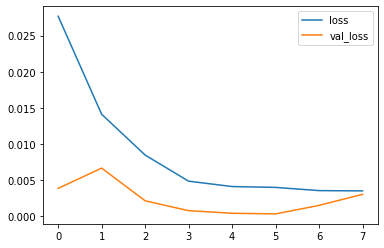

In [46]:
losses.plot()

## 3. Forecasting / Inference

## Test Split

In [47]:
# We forecast one by one all the values in the test split
# For that, the batch previous to the test split is taken
# a prediction done for it. and then,
# the batch is moved in the time to contain predicted values
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [48]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 84.63096981],
       [ 79.72709617],
       [ 85.56825631],
       [ 98.09637669],
       [108.2631739 ],
       [115.21511331],
       [119.62558163],
       [120.17600919],
       [116.03219977],
       [107.05310994],
       [ 96.98476475],
       [ 88.595061  ],
       [ 81.71231309],
       [ 79.9859095 ],
       [ 86.77413844],
       [ 98.99472729],
       [110.4439914 ],
       [118.63040321],
       [123.29221759],
       [124.24862048],
       [119.873449  ],
       [111.05594993],
       [ 99.68489892],
       [ 87.91845875]])

In [49]:
test['LSTM Predictions'] = true_predictions

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

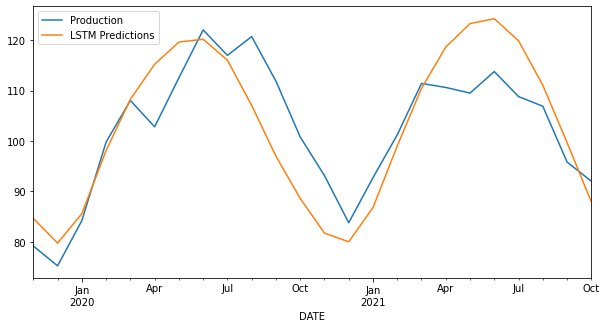

In [50]:
test.plot(figsize=(10,5))

In [54]:
# Compute the mean squared error and the RMSE
from sklearn.metrics import mean_squared_error

In [55]:
np.sqrt(mean_squared_error(test['Production'],test['LSTM Predictions']))

8.016076464307078